# Bandgap Prediction Using Patolli-Generated Descriptors  

This notebook explores bandgap prediction in materials using Patolli-generated structural descriptors.  

These descriptors capture solid-state-informed representations of material properties, providing a rich feature space for classical machine learning (ML) and deep learning (DL) models to evaluate predictive performance.

*This work is based on [gomezperalta/Patolli_2021](https://github.com/gomezperalta/patolli_2021).*


In [ ]:
#Import of required libraries and utilities
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import time
import copy
import os
import datetime
import pydot
from sklearn.utils import shuffle

Building the dataframes from the target collection and the locality functions

In [2]:
df = pd.read_pickle('./support/hseDatasetSummary.pkl')
db = pd.read_pickle('./support/hseDataset.pkl')
fij_diccio1 = np.load('./support/Rc_25_pot_2.0_diccio.npy', allow_pickle=True).item()
#fij_diccio2 = np.load('./support/Rc_25_pot_1.0_diccio.npy', allow_pickle=True).item()

In [3]:
#Checking Dataframe
'''''
display(db[(db['sg']==221) & (db['atoms']==5)])
db.keys()
display(db.loc[db['snumat_id']=='SM-9912'])
'''''
#df=df[df['sites']==3]
display(db[db['formula']=='BaTiO3'].head())
display(df.iloc[10480])

,formula,bg_gga,bg_gga_opt,bg_hse,bg_hse_opt,direct,direct_hse,icsd_number,magnetic_order,snumat_id,sg,atoms


name                                                  SM-9997
formula                                                 NbPO5
sgnum                                                      33
elements                                                    3
sites                                                       7
WyckOcc     {0: {'a': {'Nb': 1}}, 1: {'a': {'P': 1}}, 2: {...
Name: 10480, dtype: object

Work will be conducted on crystalline materials characterized by up to 10 Wyckoff sites.

### Functions for descriptor construction

In [4]:
def raw_features_extractor(sites=-1, df=pd.DataFrame):
    
    """
    Function taken from patolli.py and modified afterward.
    Parameters: 
        sites: int, it constrains the creation of the compounds collection
                to samples with a maximum number of Wyckoff sites.
    Returns:
        X: A tensor which dimensions are the samples x sites x pair atomic radius and electronegativity.
            This is saved as raw_features.npy
        S: A tensor which dimensions are the samples x sites x multiplicity of the site
            This is saved as multiplicites.npy
        fracsum: A tensor which dimensions are the samples x sites x the occupation fraction of the site
            This is saved as occupation_fractions.npy
        df: The collection of the compounds created with the function create_collection.
    """
  
    start=time.time()
    
    datos=pd.read_csv('./support/datosrahm.csv')
    datos=datos.fillna(-1)

    dicc=dict(datos[['Symbol','Z']].values)

    dicc['D']=1
    dicc['Bk']=97
    dicc['Cf']=98
    dicc['Es']=99
    dicc['Fm']=100
    dicc['Md']=101
    dicc['No']=102
    dicc['Lr']=103
    
    if sites == -1:
        max_sitios = df['sites'].max()
    else: 
        max_sitios = sites

    df=df[df['sites'] <= max_sitios].reset_index(drop=True)
    
    X=np.zeros((len(df),max_sitios,104))
    mult=np.zeros((len(df),max_sitios))
    wyckmul=np.load('./support/WyckoffSG_dict.npy', allow_pickle=True).item()['wyckmul']
    
    todelete = list()    
    for row in range(len(df)):
        
        item=df['WyckOcc'][row]
        sitios=list(item.values()) 
        sitocc=np.zeros((len(sitios),104))
        spacegroup = str(df['sgnum'][row]).zfill(3)
        
        try:
        
            s=[int(wyckmul[spacegroup][i]) for j in [list(item.keys()) for item in \
               sitios] for i in j]
        
        except:
            print('The compound with the cif ', df['cif'][row], ' will be deleted from the collection.')
            print('The collection will be updated')
            todelete += [row]
            continue
            
        occs=[]
        for i in range(len(sitios)):

            for j in list(sitios[i].values()):
                
                ocupacion=np.array(list(j.values()))
                llaves=[llave.replace('+','').replace('-','').replace('1',
                        '').replace('2','').replace('3','').replace('4',
                                   '') for llave in np.array(list(j.keys()))]
                llaves=[llave.replace('.','') for llave in llaves]
                llaves=[llave.replace('5','').replace('6','').replace('7',
                        '').replace('8','').replace('9','').replace('0',
                                   '') for llave in llaves]
                vector=np.zeros((1,104))
                occs=[sum(ocupacion)]+occs
                
                try:
                    
                    idx=[dicc[k] for k in llaves]
                
                except:
                    
                    print('The compound with the cif ', df['cif'][row], ' will be deleted from the collection.')
                    print('The collection will be updated')
                    todelete += [row]
                    continue
                    
                for k in idx:
                    vector[0][k-1] = ocupacion[idx.index(k)]
                
            sitocc[i]=vector
    
        while sitocc.shape[0] != max_sitios:
            sitocc=np.concatenate((np.zeros((1,104)),sitocc))
            s=[0]+s
        
        X[row,:,:]=sitocc
        mult[row]=s
    
    S = np.expand_dims(mult,axis=2)
    features=datos.iloc[:,2:5].values
    x=X[:,:,:96]
    print(x.shape)
    fracsum = np.expand_dims(np.sum(x,axis=2), axis=2)
    
    x=np.dot(x,features)    
    
    x = np.delete(x, todelete, axis=0)
    S = np.delete(S, todelete, axis=0)
    fracsum = np.delete(fracsum, todelete, axis=0)
    df = df.drop(df.index[todelete]).reset_index(drop=True)
    
    print('Atomic radii and electronegativities for each Wyckoff site extracted in',
          round(time.time()-start,2),' s')   
    print(features.shape)
    return x, S, fracsum, df

def add_rad_elec(X = np.ones((1,1,1))):
    """
    This function gets the average atomic radii and electronegativities per site for each compound. 
    Parameters:
	X: a Numpy array
    Returns:
	x: a Numpy array. The dimensions of the array correspond to a tensor of shape 
	(samples,1,atomic radii and electronegativites).
    """
    X = X[:,:,:2]
    x = X.reshape((X.shape[0], 1, X.shape[1]*X.shape[2]))
    return x

def compute_quotients(X = np.zeros((1,1,2))):
    """
    Returns the atomic radii pair quotients and the atomic radii 
    pair sum - quotients as a numpy array. This is the first part of
    all the features used to train the ANNs. The output of 
    this function is saved as X.npy
    
    Parameters:
        X: A numpy array, which is created with the function raw_features_extractor
    Returns:
        X: A numpy array of dimension [samples,1,features]
    """
    
    start=time.time()
    rad = X[:,:,1]

    drad = np.asarray([[item[0]/item[1] if item[1] != 0 else 0 for item in list(itertools.combinations(rad[sample],2))] \
                        for sample in range(X.shape[0])])

    dradsum = np.asarray([[item[0]/item[1] if item[1] != 0 else 0 for item in itertools.combinations([ \
                       item[0]+item[1] for item in list(itertools.combinations(rad[sample],2))], 2)] \
                       for sample in range(drad.shape[0])])
    
    drad = np.reshape(drad,(drad.shape[0],1,drad.shape[-1]))
    drads = np.reshape(dradsum,(dradsum.shape[0],1,dradsum.shape[-1]))
    
    Xq = np.concatenate((drad,drads), axis=2)
    print('Geometric and packing factors computed in', round(time.time()-start,2),' s')
    #np.save('X', Xq)
    
    return Xq

def append_local_functions(X = np.zeros((1,1,1)), df = pd.DataFrame(), 
                           local_function='./support/Rc_25_pot_2.0_diccio'):
    """
    Returns the features with the local functions. In case the local function
    does not exist for a sample in the collection, this is deleted and the
    collection is updated. The X.npy is updated.
    
    Parameters:
        X: The numpy array created with compute_quotients
        df: The pandas DataFrame created with raw_features_extractor
        local_function: The numpy dictionary having the local function to use.
    Returns:
        X: The numpy array with all neccesary features for the ANNs.
        df: The pandas DataFrame updated.
    """
    start = time.time()
    print('The dictionary ' + local_function + ' will be used for local functions')
    fij = np.load(local_function + '.npy', allow_pickle=True).item()
    
    delrow = list()
    n = df['sites'].max()
    
    f = np.zeros((df.shape[0],n,n))
    
    for row in range(df.shape[0]):
        if df['name'][row] not in fij.keys():
            delrow += [row]
        else:
            loc = fij[df['name'][row]]
            s = loc.shape[1]
            f[row,-s:,-s:] = loc
    
    if len(delrow) != 0:
        
        print('The compounds with the next cifs will be deleted since ',
              'their local functions are not currently available')
        print([df['name'][i] for i in delrow])
        print('The compound collection will be updated')
        
        totake = [i for i in range(df.shape[0]) if i not in delrow]
        df = df.take(totake).reset_index(drop=True)
        X = X[totake]
        f = f[totake]
        #df.to_csv('compounds_collection.csv', index=None)
    '''
    #Esta parte trabaja para las funciones de localidad cuando incorporan la diferencia de electronegatividades
    
    fn = np.zeros((f.shape[0], f.shape[1], f.shape[2] - 1))        
    for item in range(f.shape[0]):
        delec = f[item]
        delec = delec[~np.eye(delec.shape[0], dtype=bool)].reshape(delec.shape[0],-1)
        fn[item] = delec
    
    f = fn
    '''
    f = f.reshape((f.shape[0], 1, f.shape[1]*f.shape[2]))
    print(X.shape, f.shape)
    
    X = np.concatenate((X,f), axis = 2)
    print('Local functions appended to features in ', round(time.time()-start,2),' s')
    return X, df


The process begins with the construction of descriptors for each sample. If this is not feasible, the sample is discarded and the collection summary is updated accordingly.

In [5]:
xraw, multiplicity, fracSum, df = raw_features_extractor(sites=10, df=df)

notANobleGas = [i for i in np.argwhere((xraw == -1).sum(axis=(1,2)) == 0)[:,0]]

if len(notANobleGas):
    print('Dropping rows having a noble gas in the formula')
    print('There are', len(notANobleGas),'rows remaining')

xraw = xraw[notANobleGas]
multiplicity= multiplicity[notANobleGas]
fracSum = fracSum[notANobleGas]
df = df.iloc[notANobleGas,:].reset_index(drop=True)
print(xraw.shape)
df.shape

(9290, 10, 96)
Atomic radii and electronegativities for each Wyckoff site extracted in 0.55  s
(96, 2)
Dropping rows having a noble gas in the formula
There are 9275 rows remaining
(9275, 10, 2)


(9275, 6)

In [6]:
x = add_rad_elec(X = xraw)
xq = compute_quotients(xraw)
#x = np.concatenate((x, xq), axis=-1)
display(pd.DataFrame(x[2,0,:]))

Geometric and packing factors computed in 1.89  s


,0
0,0.00
1,0.00
2,0.00
3,0.00
4,0.00
5,0.00
6,0.00
7,0.00
8,0.00
9,0.00


Append different locality functions

In [7]:
x,df = append_local_functions(x, df,local_function='./support/Rc_25_pot_2.0_diccio')

The dictionary ./support/Rc_25_pot_2.0_diccio will be used for local functions
The compounds with the next cifs will be deleted since  their local functions are not currently available
['SM-10200', 'SM-10269', 'SM-10928', 'SM-10937', 'SM-11313', 'SM-11551', 'SM-11563', 'SM-11632', 'SM-11634', 'SM-11638', 'SM-11688', 'SM-11689', 'SM-11862', 'SM-11893', 'SM-1196', 'SM-12014', 'SM-12032', 'SM-12079', 'SM-12098', 'SM-12129', 'SM-12142', 'SM-12147', 'SM-12164', 'SM-1223', 'SM-12285', 'SM-1229', 'SM-1237', 'SM-12453', 'SM-12552', 'SM-12675', 'SM-12679', 'SM-12975', 'SM-13001', 'SM-13002', 'SM-13061', 'SM-13078', 'SM-13151', 'SM-13219', 'SM-13286', 'SM-13329', 'SM-13349', 'SM-13382', 'SM-13396', 'SM-13406', 'SM-13419', 'SM-13420', 'SM-13422', 'SM-13458', 'SM-13479', 'SM-13487', 'SM-13504', 'SM-13517', 'SM-13549', 'SM-13568', 'SM-13570', 'SM-13826', 'SM-13945', 'SM-14005', 'SM-14013', 'SM-14022', 'SM-14039', 'SM-14040', 'SM-14110', 'SM-14169', 'SM-14246', 'SM-14248', 'SM-15062', 'SM-15094', 'S

In [8]:
#manual array checking
display(x[2,0,:])

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.6       ,
       2.51      , 2.05      , 2.46      , 2.2       , 2.37      ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

Descriptor construction is complete. Band gap information will be collected to generate output values.

In [9]:
idxdiccio = {k:v for v,k in enumerate(db.snumat_id.values)}
y = db.iloc[[idxdiccio[df['name'][row]] for row in range(df.shape[0])]][['bg_gga', 'bg_gga_opt', 'bg_hse', 'bg_hse_opt']].values


In [10]:
patolli_complete=pd.concat([df['name'],pd.DataFrame(y)],axis=1)
patolli_complete.columns = ['cif'] + ['bg_gga', 'bg_gga_opt', 'bg_hse', 'bg_hse_opt']
patolli_complete.shape

(9062, 5)

Output values distribution.

In [11]:
y.mean(axis=0), y.std(axis=0), y.max(axis=0), y.min(axis=0)

(array([1.74408222, 2.40261587, 2.80793064, 3.52104157]),
 array([1.25422112, 1.67128289, 1.55570872, 1.92821398]),
 array([10.114853, 24.270356, 12.495444, 26.906879]),
 array([ 0.      ,  0.      , -0.054436, -0.054436]))

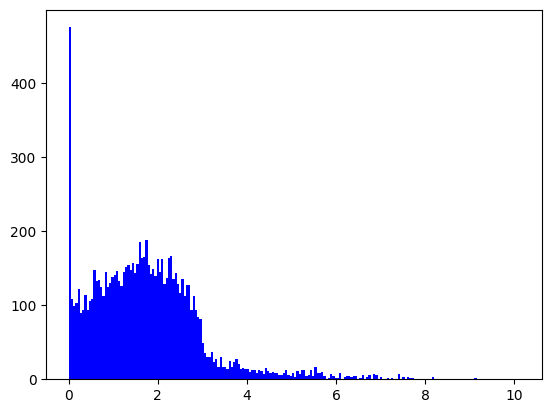

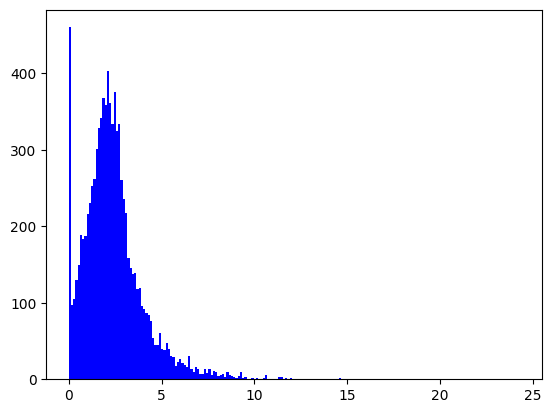

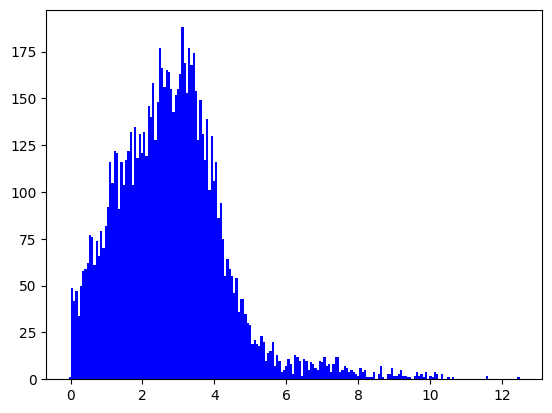

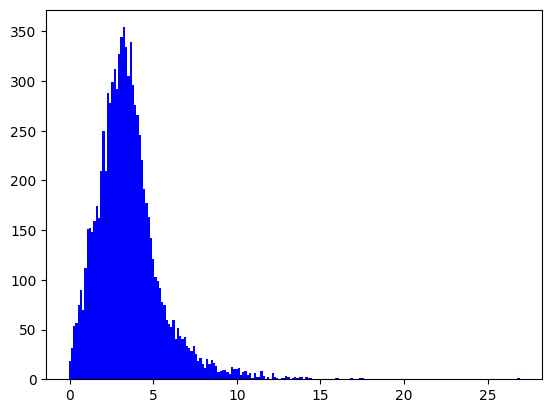

In [12]:
for outputValue in range(4):
    
    plt.figure()
    plt.hist(y[:,outputValue], bins=200, color='blue')
    plt.show()

Band gaps will be constrained to a range between 0 and the mean value plus three standard deviations. The sample collection (df) and the descriptor collection (x) are then updated.

In [13]:
conditions = dict()
for row in range(y.shape[-1]):
    conditions[row] = np.intersect1d(np.argwhere(0 < y[:,row])[:,0], np.argwhere(y[:,row] <= y[:,row].mean() + 2*y[:,row].std())[:,0])


idxRightOutputs = np.intersect1d(np.intersect1d(conditions[0], conditions[1]), np.intersect1d(conditions[2], conditions[3]))

x = x[idxRightOutputs]
y = y[idxRightOutputs]
df = df.iloc[idxRightOutputs].reset_index(drop=True)
df.shape

(8134, 6)

In [14]:
display(pd.DataFrame(x[:,0,:]).tail(5))

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
8129,0.00,0.00,0.93,2.25,0.93,2.25,2.55,2.24,0.93,2.25,...,0.000000,0.497898,0.286886,0.644390,1.367514,0.850374,1.051299,1.141401,1.035106,0.649525
8130,0.00,0.00,0.93,2.25,0.93,2.25,2.55,2.24,0.93,2.25,...,0.000000,0.482575,0.237315,0.556164,1.259390,0.690779,1.087107,1.113451,1.005326,0.601647
8131,1.83,2.26,1.83,2.26,1.83,2.26,1.83,2.26,3.44,1.71,...,2.802549,2.995308,3.199055,2.787138,1.555073,1.902128,1.913913,1.891030,1.869768,1.394507
8132,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.172815,0.462255,0.752096,1.570956
8133,0.00,0.00,0.00,0.00,0.00,0.00,1.60,2.51,2.19,2.23,...,0.000000,0.000000,0.000000,3.575354,3.018098,1.969407,1.831530,2.029441,2.038142,1.086154


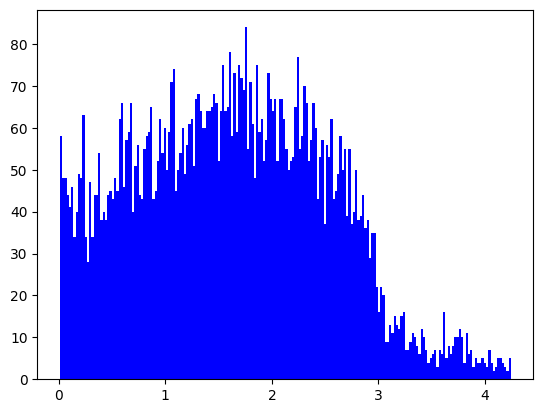

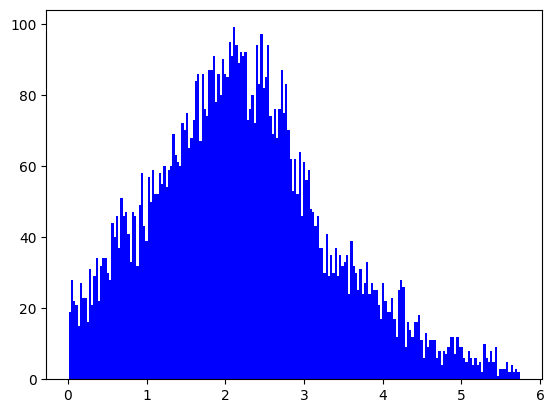

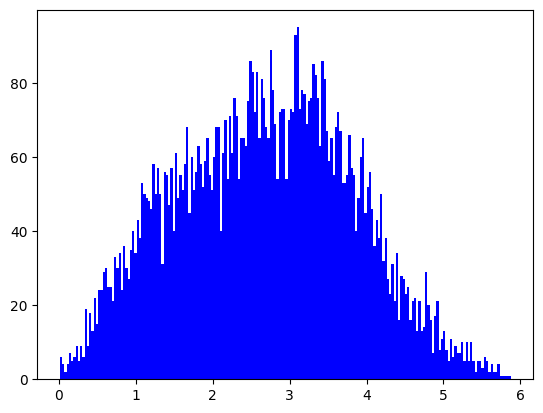

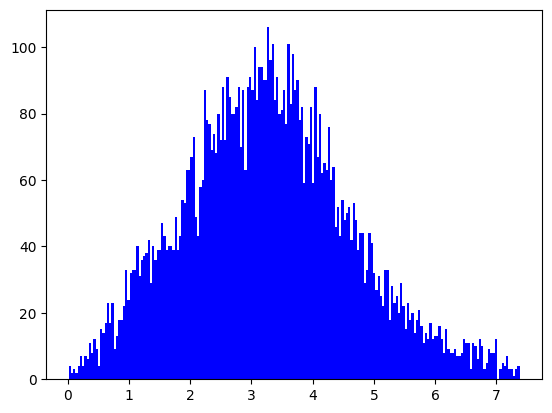

In [15]:
for outputValue in range(4):
    
    plt.figure()
    plt.hist(y[:,outputValue], bins=200, color='blue')
    plt.show()

K-means clustering analysis

In [16]:
from sklearn.cluster import KMeans
def Kmeans_clustering(x):
    xnorm=x.reshape(8134, 120)
    kmeans = KMeans(n_clusters=3,init='k-means++',tol=0.00001, random_state=0,verbose=0)
    kmeans.fit_predict(xnorm)
    kmeans_labels =kmeans.labels_
    #cluster_centers = kmeans.cluster_centers_
    xnorm = np.column_stack((xnorm, kmeans_labels))
    xnorm = xnorm.reshape(8134, 1, 121)
    print(xnorm.shape)
    return xnorm

(8134, 1, 121)


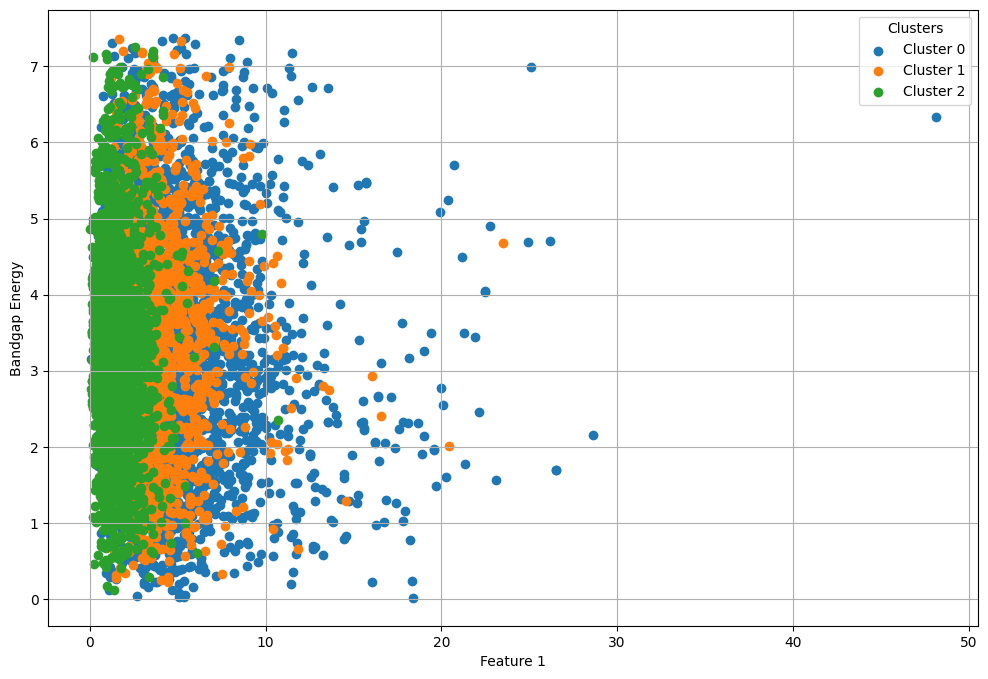

In [17]:
xcluster=Kmeans_clustering(x)
plt.figure(figsize=(12, 8))

# Plot each cluster with a different label
for cluster in set(xcluster[:, 0, -1]):
    mask = xcluster[:, 0, -1] == cluster
    plt.scatter(xcluster[mask, 0, -2], y[mask, -1], label=f'Cluster {int(cluster)}', alpha=1)

plt.xlabel("Feature 1")
plt.ylabel("Bandgap Energy")
plt.legend(title="Clusters")
plt.grid(True)
plt.show()


### Evaluation of descriptor scaling methods.

Z-score

In [18]:
def Z_score(x, axis=(0, 1)):
    mean = np.mean(x, axis=axis, keepdims=True)
    std = np.std(x, axis=axis, keepdims=True)
    std = np.where(std == 0, 1e-8, std)
    #display(pd.DataFrame(xnorm[:,0,:]))
    xnorm = (x - mean) / std
    return xnorm

RobustScaler

In [19]:
def RobustScaler(x):
    reshaped_x = np.squeeze(x)
    # Calculate the median and IQR for each feature
    median_values = np.median(reshaped_x, axis=0)
    q1_values = np.percentile(reshaped_x, 25, axis=0)
    q3_values = np.percentile(reshaped_x, 75, axis=0)

    # Avoid division by zero (in case IQR is zero)
    epsilon = 1e-20

    # Perform robust scaling manually
    xnorm = (reshaped_x - median_values) / (q3_values - q1_values + epsilon)
    # Reshape back to the original shape
    xnorm = xnorm.reshape(8134, 1, 120)
    return xnorm    

MaxAbs

In [20]:
def MaxAbs(x):
    reshaped_x = np.squeeze(x)
    # Calculate the maximum absolute value for each feature
    maxabs_values = np.max(np.abs(reshaped_x), axis=0)

    # Avoid division by zero (in case maxabs value is zero)
    epsilon = 1e-20

    # Perform MaxAbs scaling manually
    xnorm = reshaped_x / (maxabs_values + epsilon)

    # Reshape back to the original shape
    xnorm= xnorm.reshape(8134, 1, 120)
    return xnorm

Unit Variance

In [21]:
def UnitVariance(x):
    reshaped_x = np.squeeze(x)
    # Calculate the mean and variance for each feature
    mean_values = np.mean(reshaped_x, axis=0)
    variance_values = np.var(reshaped_x, axis=0)

    # Avoid division by zero (in case variance is zero)
    epsilon = 1e-20

    # Perform Unit Variance scaling manually
    xnorm = (reshaped_x - mean_values) / np.sqrt(variance_values + epsilon)

    # Reshape back to the original shape
    xnorm = xnorm.reshape(8134, 1, 120)
    return xnorm

MaxMin

In [22]:
def MaxMin(x):
    reshaped_x = np.squeeze(x)
    min_values = reshaped_x.min(axis=0)
    max_values = reshaped_x.max(axis=0)
    epsilon = 1e-20
    xnorm = (reshaped_x - min_values) / (max_values - min_values + epsilon)
    xnorm = xnorm.reshape(8134, 1, 120)
    return xnorm


In [23]:
#Normalize

xnorm=Z_score(x,axis=(0,1))

### Building the dataframe for concatenating diffractogram‑derived features

In [24]:
patolli_df=pd.concat([df['name'],pd.DataFrame(xnorm[:,0,:]),pd.DataFrame(y)],axis=1)
patolli_df.columns = ['cif']+list(patolli_df.columns[1:-4]) + ['bg_gga', 'bg_gga_opt', 'bg_hse', 'bg_hse_opt']
patolli_y=pd.concat([df['name'],pd.DataFrame(y)],axis=1)
patolli_y.columns = ['cif'] + ['bg_gga', 'bg_gga_opt', 'bg_hse', 'bg_hse_opt']
patolli_y.shape



(8134, 5)

### Splitting the full dataset into training–validation and test sets

In [25]:
testFraction = 0.10

In [26]:
np.random.choice.__doc__.split('\n')# df.shape[0]
np.random.seed(3451)
idxtest = np.random.choice(range(df.shape[0]), size = int(testFraction*df.shape[0]), replace=False)
idxtraval = [i for i in range(df.shape[0]) if i not in idxtest]

xtravalOr = xnorm[idxtraval]
xtest = xnorm[idxtest]

ytravalOr = y[idxtraval]
ytest = y[idxtest]

dftravalOr = df.iloc[idxtraval].reset_index(drop=True)
dftest = df.iloc[idxtest].reset_index(drop=True)

In [27]:
#np.save('patolli_xtest.npy', xtest)
#np.save('patolli_ytest.npy',ytest)
print(xtest.shape)

(813, 1, 120)


### Randomization

In [28]:
xtraval, ytraval, dftraval = shuffle(xtravalOr, ytravalOr, dftravalOr, random_state=3451)
xtraval, ytraval, dftraval = shuffle(xtraval, ytraval, dftraval, random_state=3451)
xtraval, ytraval, dftraval = shuffle(xtraval, ytraval, dftraval, random_state=3451)
print(xtraval.shape, ytraval.shape, dftraval.shape)

(7321, 1, 120) (7321, 4) (7321, 6)


### Classical machine learning–based predictive modeling algorithms

In [29]:
#Import classical machine learning utilities
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as PRFS
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
import sklearn.linear_model
import sklearn.neighbors
import sklearn.ensemble
from xgboost import XGBRegressor

In [30]:
#To manually review statistical indicators
sklearn_mae=[]
sklearn_rmse=[]
sklearn_scores={}

Linear Regression

mae: [0.66949885 0.80228825 0.7580828  0.90821051]
rmse: [0.84925122 1.02928269 0.96683773 1.16798361]


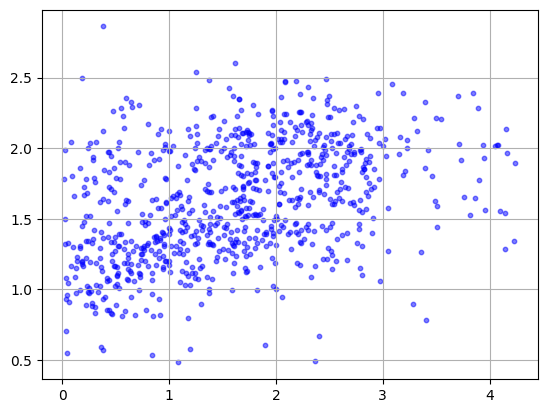

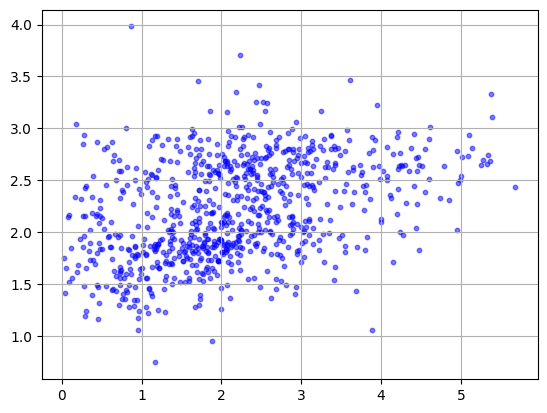

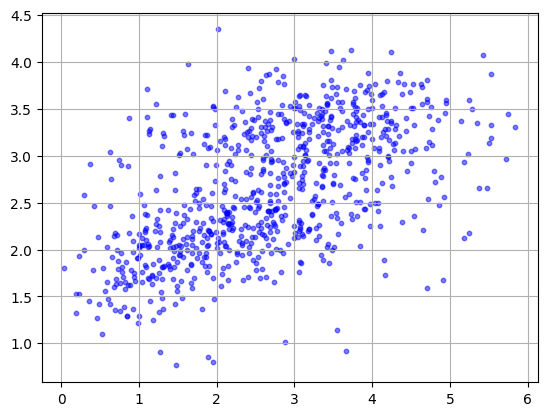

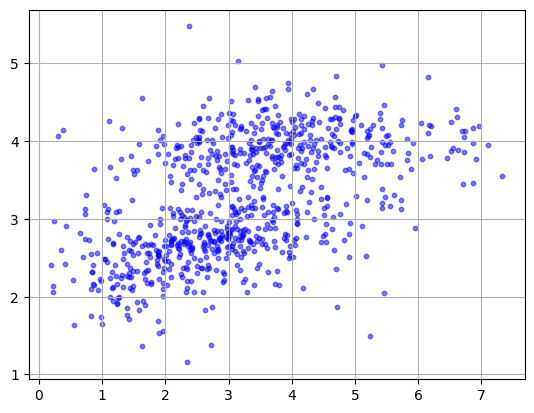

In [31]:
reg = sklearn.linear_model.LinearRegression()
reg.fit(xtraval[:,0,:],ytraval)

ptest = reg.predict(xtest[:,0,:])

mae=abs(ytest-ptest).mean(axis=0)
rmse=((ytest-ptest)**2).mean(axis=0)**0.5
print('mae:', mae)
print('rmse:', rmse)
sklearn_mae = mae.tolist()
sklearn_rmse = rmse.tolist()
sklearn_score=sklearn_mae+sklearn_rmse
sklearn_scores['Linear']=sklearn_score

for item in range(y.shape[-1]):
    plt.figure()
    plt.scatter(ytest[:,item],ptest[:,item], s=10, color='blue', alpha=0.5)
    plt.grid(True)
    plt.show()

Kneighbors Regressor

mae: [0.58897598 0.74009472 0.68274594 0.84084744]
rmse: [0.77328047 0.97136266 0.88910696 1.09643545]


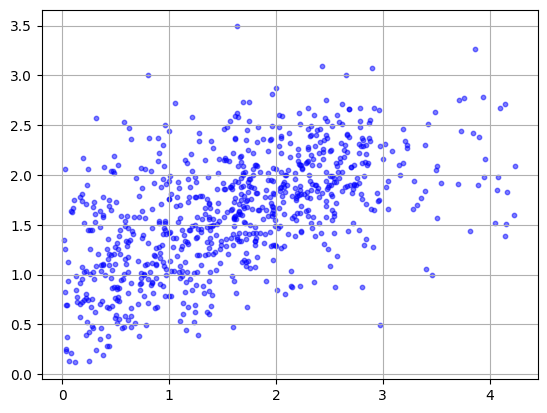

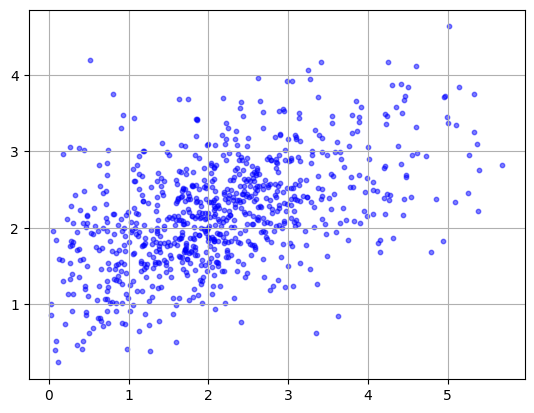

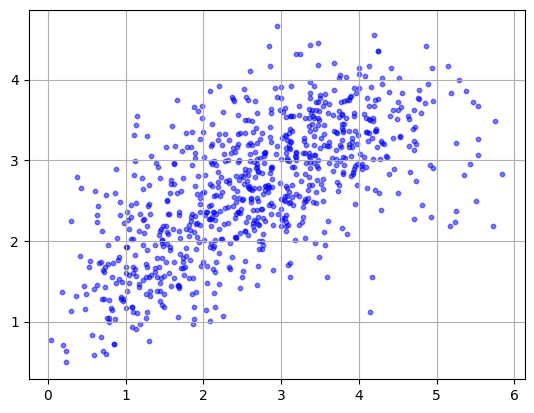

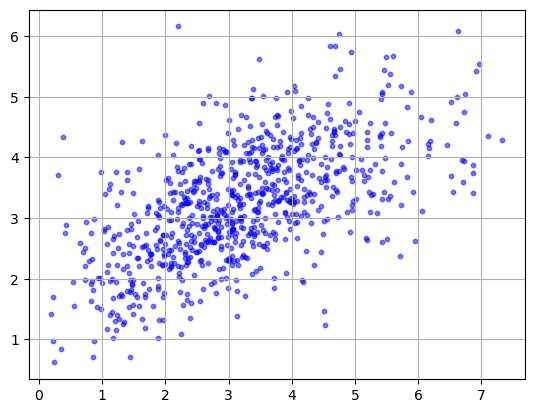

In [32]:
knn = sklearn.neighbors.KNeighborsRegressor()
knn.fit(xtraval[:,0,:],ytraval)

ptest = knn.predict(xtest[:,0,:])

mae=abs(ytest-ptest).mean(axis=0)
rmse=((ytest-ptest)**2).mean(axis=0)**0.5
print('mae:', mae)
print('rmse:', rmse)
sklearn_mae = mae.tolist()
sklearn_rmse = rmse.tolist()
sklearn_score=sklearn_mae+sklearn_rmse
sklearn_scores['KNeighbors']=sklearn_score


for item in range(y.shape[-1]):
    plt.figure()
    plt.scatter(ytest[:,item],ptest[:,item], s=10, color='blue', alpha=0.5)
    plt.grid(True)
    plt.show()

Random Forest Regressor

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s


building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.9s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


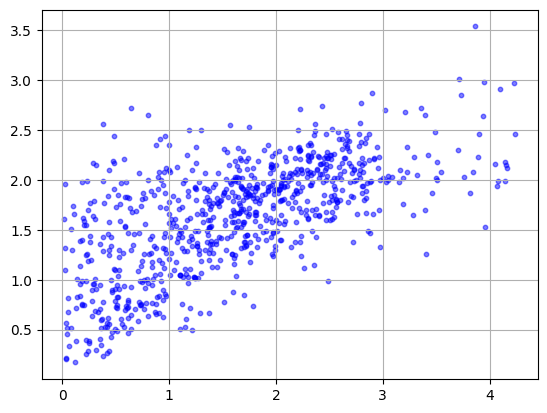

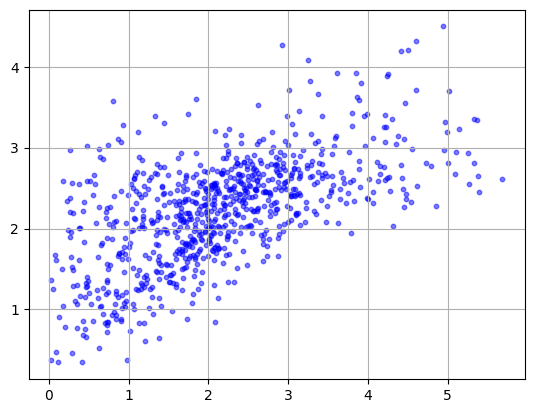

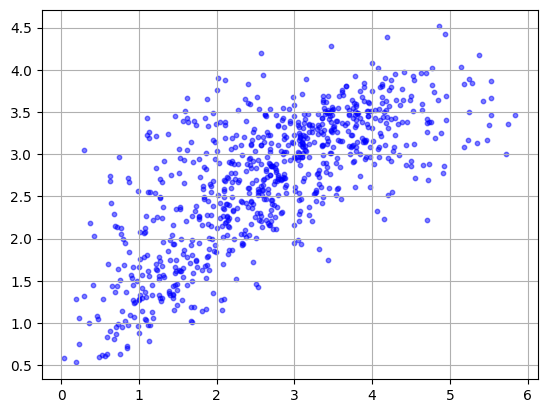

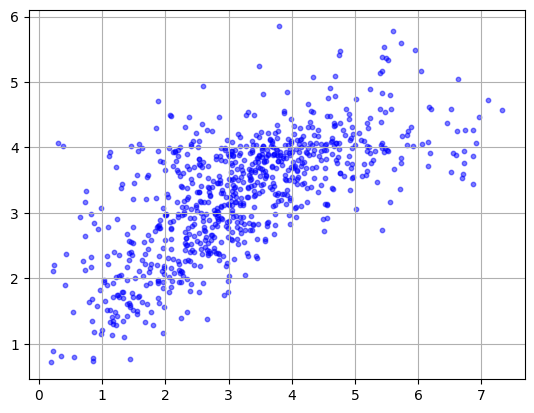

In [33]:
rf = sklearn.ensemble.RandomForestRegressor(n_jobs = -1, verbose=2,random_state=3451)
rf = rf.fit(xtraval[:,0,:], ytraval)

ptest = rf.predict(xtest[:,0,:])

mae=abs(ytest-ptest).mean(axis=0)
rmse=((ytest-ptest)**2).mean(axis=0)**0.5
print('mae:', mae)
print('rmse:', rmse)
sklearn_mae = mae.tolist()
sklearn_rmse = rmse.tolist()
sklearn_score=sklearn_mae+sklearn_rmse
sklearn_scores['RandomForest']=sklearn_score

for item in range(y.shape[-1]):
    plt.figure()
    plt.scatter(ytest[:,item],ptest[:,item], s=10, color='blue', alpha=0.5)
    plt.grid(True)
    plt.show()

XGBoost Regressor

mae: [0.54449938 0.67389003 0.60429994 0.74631157]
rmse: [0.70638188 0.88158695 0.78711917 0.97851097]


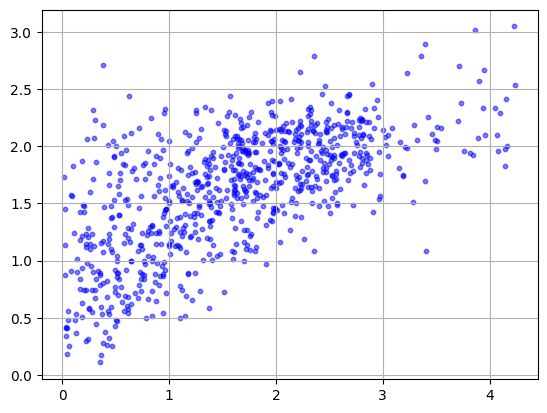

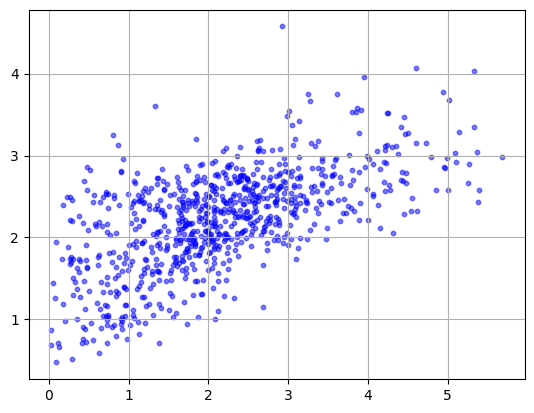

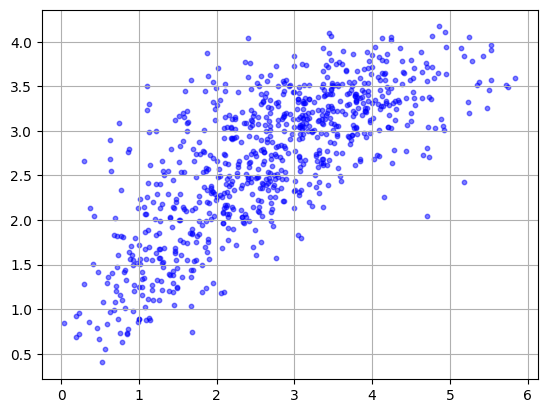

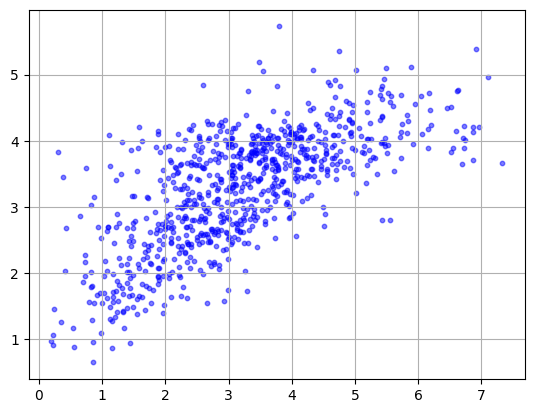

In [34]:

xgb = XGBRegressor(learning_rate=0.1,objective='reg:squarederror',random_state=3451)
xgb.fit(xtraval[:,0,:], ytraval)
ptest = xgb.predict(xtest[:,0,:])

mae=abs(ytest-ptest).mean(axis=0)
rmse=((ytest-ptest)**2).mean(axis=0)**0.5
print('mae:', mae)
print('rmse:', rmse)
sklearn_mae = mae.tolist()
sklearn_rmse = rmse.tolist()
sklearn_score=sklearn_mae+sklearn_rmse
sklearn_scores['XGBRegressor']=sklearn_score

#xgb.save_model('models/xgboost_patolli_model.xgb')
for item in range(y.shape[-1]):
    plt.figure()
    plt.scatter(ytest[:,item],ptest[:,item], s=10, color='blue', alpha=0.5)
    plt.grid(True)
    plt.show()

In [35]:
#Manual metric review 
bg_list=['bg_gga', 'bg_gga_opt', 'bg_hse', 'bg_hse_opt']
bg_list = [f'mae_{i}' for i in bg_list] + [f'rmse_{i}' for i in bg_list]
sklearn_scores=pd.DataFrame.from_dict(sklearn_scores,orient='index')
sklearn_scores.columns=bg_list
display(sklearn_scores)


,mae_bg_gga,mae_bg_gga_opt,mae_bg_hse,mae_bg_hse_opt,rmse_bg_gga,rmse_bg_gga_opt,rmse_bg_hse,rmse_bg_hse_opt
Linear,0.669499,0.802288,0.758083,0.908211,0.849251,1.029283,0.966838,1.167984
KNeighbors,0.588976,0.740095,0.682746,0.840847,0.773280,0.971363,0.889107,1.096435
RandomForest,0.528008,0.658379,0.592920,0.737173,0.705360,0.885847,0.799530,0.997109
XGBRegressor,0.544499,0.673890,0.604300,0.746312,0.706382,0.881587,0.787119,0.978511


### Deep learning–based predictive modeling approaches

In [36]:
#Deep learning imports
from tensorflow.keras.utils import model_to_dot
import pydot
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, LayerNormalization, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from keras_tuner import BayesianOptimization
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
"""
import tensorflow.keras.utils as kutils
import tensorflow.keras.callbacks as callbacks
import tensorflow.keras.optimizers as optimizer
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, LayerNormalization, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import model_to_dot
from keras_tuner import BayesianOptimization
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
"""

2025-09-19 22:47:32.323625: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-19 22:47:32.336511: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-19 22:47:32.340978: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-19 22:47:32.352836: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-19 22:47:33.154810: W tensorflow/compiler/tf2

'\nimport tensorflow.keras.utils as kutils\nimport tensorflow.keras.callbacks as callbacks\nimport tensorflow.keras.optimizers as optimizer\nfrom tensorflow.keras import Input, Model\nfrom tensorflow.keras.layers import Dense, LayerNormalization, Activation, Dropout\nfrom tensorflow.keras.optimizers import Adam\nfrom tensorflow.keras.utils import plot_model\nfrom tensorflow.keras.utils import model_to_dot\nfrom keras_tuner import BayesianOptimization\nfrom tensorflow import keras\nfrom tensorflow.keras import layers\nfrom tensorflow.keras.callbacks import EarlyStopping\n'

In [37]:
def create_model(xt,yt,neurons,blocks,drop,lr):
    """
    Function to build deep neural network architectures using TensorFlow's Functional API.
    Parameters: 
        xt: array-like, Training input data (features or descriptors).
        yt: array-like, Training target values (labels or regression targets).
        neurons: int, Number of neurons per hidden layer.
        blocks: int,Number of hidden layers (network depth).
        drop: float, Dropout rate between 0.0 and 1.0.
        lr: float, Learning rate for the optimizer.
    Returns:
        model:tensorflow.keras.Model, Compiled TensorFlow Keras model ready for training.
    """
    # Input layer
    inputs = Input(shape=xt.shape[1:])
    neurons=int(neurons)
    # Initialize 'x' with the inputs
    x = inputs
    x_shortcut=x

    # Add 'num_blocks' blocks
    for _ in range(blocks-1):
        x = Dense(neurons)(x)
        x = LayerNormalization()(x)
        x = layers.Activation('relu')(x)
        x = Dropout(drop)(x)
    
    x = Dense(neurons//2)(x)
    x = LayerNormalization()(x)
    x = layers.Activation('relu')(x)
    x = Dropout(drop)(x)       
    '''''
        if _%2!=0:
            x = Dense(neurons)(x)
            x = LayerNormalization()(x)
            x = layers.Activation('relu')(x)
            x = Dropout(drop)(x)
        else:
            x_shortcut= Dense(neurons)(x_shortcut)
            x_shortcut= LayerNormalization()(x_shortcut)
            x_shortcut= layers.Activation('relu')(x_shortcut)
            x_shortcut= Dropout(d)(x_shortcut)
            x = Dense(neurons)(x)
            x = LayerNormalization()(x)
            x = layers.Activation('relu')(x)
            x = Dropout(drop)(x)    
            x = layers.add([x,x_shortcut])  
            x_shortcut=x
            '''
    #x=layers.add([x,x_shortcut])               
    outputs = Dense(yt.shape[-1], activation='linear')(x)

    model = Model(inputs=inputs, outputs=outputs)

    optim = Adam(learning_rate=lr)
    model.compile(loss='log_cosh', optimizer=optim, metrics=['mse'])

    return model

In [38]:
def create_model2(xt,yt,neurons,blocks,drop,lr):
    """
    Function to create the deep neural network architecture using TensorFlow's Functional API.
    Parameters: 
        xt: array-like, Training input data (features or descriptors).
        yt: array-like, Training target values (labels or regression targets).
        neurons: int, Number of neurons per hidden layer.
        blocks: int,Number of hidden layers (network depth).
        drop: float, Dropout rate between 0.0 and 1.0.
        lr: float, Learning rate for the optimizer.
    Returns:
        model: tensorflow.keras.Model, Compiled TensorFlow Keras model ready for training.
    """
    inputs = Input(shape=xt.shape[1:])

    x = inputs
    x2= inputs
    x3= inputs
    for _ in range(blocks):
            x = Dense(neurons)(x)
            x = LayerNormalization()(x)
            x = layers.Activation('relu')(x)
            x = Dropout(drop)(x) 
            x2 = Dense(neurons)(x2)
            x2 = LayerNormalization()(x2)
            x2 = layers.Activation('relu')(x2)
            x2 = Dropout(drop)(x2)
            x3 = Dense(neurons)(x3)
            x3 = LayerNormalization()(x3)
            x3 = layers.Activation('relu')(x3)
            x3 = Dropout(drop)(x3)
    
    x=layers.add([x,x2,x3])
    outputs = Dense(yt.shape[-1], activation='linear')(x)

    model = Model(inputs=inputs, outputs=outputs)
    
    # Load previous weights into the model
    #model.load_weights('June_12_202457_2024_concat_0.0001_2960_0.1_128_2_blocks_150__O/June_12_202457_2024_concat_0.0001_2960_0.1_128_2_blocks_150.keras', skip_mismatch=True)

    optim = Adam(learning_rate=lr)
    model.compile(loss='log_cosh', optimizer=optim, metrics=['mse'])

    return model



In [39]:
def plot_graphs(history, model_dir, ytest, ptest):
    """
    Function to plot model performance visualizations and metrics.
    Parameters: 
        history : training history object returned by `model.fit()`, containing loss and metric values per epoch.
        model_dir:str, name of the model, used for plot titles and saved file names.
        ytest: array-like, actual target values from the test set.
        ptest: array-like, predicted target values from the model on the test set.
    Returns:
        None
        Saves PNG images of:
        - Training loss and metric curves over epochs.
        - Histogram comparing actual vs. predicted values.
        - Scatter plot of actual vs. predicted values.
    """
    # Plot the loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train','Val'], loc='upper right')
    # Plot mse
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mse'])
    plt.plot(history.history['val_mse'])
    plt.title('Model mse')
    plt.ylabel('mse')
    plt.xlabel('Epoch')
    plt.legend(['Train','Val'], loc='upper right')
    
    plt.savefig(f'{model_dir}/loss_mse_plot.png')
    plt.close()
    # Plot predicted vs real values
    for item in range(y.shape[-1]):
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.scatter(ytest[:,item],ptest[:,item], s=10, color='purple', alpha=0.5)
        plt.grid()
        plt.xlabel(r'actual band gap (eV)')
        plt.ylabel(r'predicted bandgap (eV)')
    #plt.plot(np.arange(-1,7), np.arange(-1,7), linewidth=1, color='black')
        plt.title('Actual vs Predicted Values')
    # Plot histograms of actual and predicted values
        ytest_plot = ytest[:,item]
        ptest_plot = ptest[:,item]
        plt.subplot(1, 2, 2)
        plt.hist(ytest_plot, bins=200, color='blue')
        plt.hist(ptest_plot, bins=200, color='red', alpha=0.5)
        plt.title('Histogram of Actual and Predicted Values')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.legend(['Actual', 'Predicted'], loc='upper right')
    
        plt.savefig(f'{model_dir}/real_vs_predicted_{item}.png')
        plt.close()
    
    for item in range(y.shape[-1]):
        residuals = ytest[:,item] - ptest[:,item]
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.hist(residuals, bins=50, color='blue', alpha=0.5)
        plt.title('Histogram of Actual and Predicted Values')
        plt.xlabel('E_actual-E_predicted (eV)')
        plt.ylabel('Frequency')
    
        plt.savefig(f'{model_dir}/Distribution_{item}.png')
        plt.close()

In [40]:

class BandgapModel:
    """
    Deep learning model wrapper for band gap prediction.

    This class encapsulates the creation, training, and evaluation of deep neural
    networks for supervised band gap prediction tasks. It supports multiple
    architecture versions and uses TensorFlow's Functional API for model
    construction.

    Parameters
    ----------
    neurons : int, optional (default=64), number of neurons per hidden layer.
    blocks : int, optional (default=3), number of hidden layers (network depth).
    drop : float, optional (default=0.2), dropout rate between 0.0 and 1.0 applied to reduce overfitting.
    lr : float, optional (default=0.001), learning rate for the optimizer.
    version : int, optional (default=1), model architecture version. If 1, uses `create_model`; otherwise uses `create_model2`.

    Attributes
    ----------
    model : tensorflow.keras.Model or None, The compiled Keras model instance after calling `build()`.
    history : tensorflow.keras.callbacks.History or None, Training history object after calling `fit()`.

    Methods
    -------
    build(xtraval, ytraval), construct the model architecture based on the specified version and parameters.
    fit(xtraval, ytraval, validation_split, epoch, batch, verbose=2), train the model on the provided training data.
    evaluate_model(xtraval, ytraval, xtest, ytest, model_name, batch, epoch), fit the model and perform evaluation on the test set.
    """

    def __init__(self, neurons=64, blocks=3, drop=0.2, lr=0.001, version=1):
        self.neurons = neurons
        self.blocks = blocks
        self.drop = drop
        self.lr = lr
        self.version = version
        self.model = None
        self.history = None

    def build(self, xtraval, ytraval):
        if self.version == 1:
            self.model = create_model(xtraval, ytraval, self.neurons, self.blocks, self.drop, self.lr)
        else:
            self.model = create_model2(xtraval, ytraval, self.neurons, self.blocks, self.drop, self.lr)
        return self.model

    def fit(self, xtraval, ytraval, validation_split=0.11, epoch=1, batch=1, verbose=2):
        if self.model is None:
            raise ValueError("Call build() before fit().")
        self.history = self.model.fit(
            xtraval, ytraval,
            validation_split=validation_split, 
            batch_size=batch,
            epochs=epoch,
            verbose=verbose
        )
        return self.history

    def evaluate_model(self, xtraval, ytraval, xtest, ytest, model_name, batch, epoch=3):
        history = self.fit(
            xtraval, ytraval,
            validation_split=0.11,
            epoch=epoch,
            batch=batch
        )
        ptraval = self.model.predict(xtraval)
        ptest = self.model.predict(xtest)
        model_dir=f'models/{model_name}'
        # Save predictions
        np.save(f'{model_dir}/{model_name}_ptrav', ptraval)
        np.save(f'{model_dir}/{model_name}_ptest', ptest)
        
        # Metrics
        msetraval = mse(ytraval, ptraval)
        msetest = mse(ytest, ptest)
        maetraval = mae(ytraval, ptraval)
        maetest = mae(ytest, ptest)
        mae_nn = abs(ytest - ptest).mean(axis=0)
        rmse_nn = ((ytest - ptest)**2).mean(axis=0)**0.5
        
        # Save metrics to file
        with open(f'{model_dir}/mse_mae.txt', 'a') as f:
            f.write(model_name)
            f.write(',')
            f.write("%.5f" % msetraval)
            f.write(',')
            f.write("%.5f" % msetest)
            f.write(',')
            f.write("%.5f" % maetraval)
            f.write(',')
            f.write("%.5f" % maetest)
            f.write('\n\n')
            f.write(' mae:')
            f.write(str(mae_nn))
            f.write('\n')
            f.write(' rmse:')
            f.write(str(rmse_nn))
        
        # Save model + plot
        self.model.save(f'{model_dir}/{model_name}.keras')
        plot_model(self.model, to_file=f'{model_dir}/model_architecture.png', show_shapes=True)
        
        # Plot training curves
        plot_graphs(history, model_dir, ytest, ptest)



Hyperparameter sweep: grid definition and loop

In [41]:
# Define hyperparameter tuning ranges
lrs = [1e-4]
batch_sizes = [32]
epochs = [2]
blocks = [1, 2]
drops = np.arange(0.0, 0.5, 0.5)
neurons_list = range(2800, 2801, 280)

for block, drop, batch, neurons, lr, epoch in itertools.product(
        blocks, drops, batch_sizes, neurons_list, lrs, epochs):

    bandgap = BandgapModel(
        neurons=neurons, 
        blocks=block, 
        drop=drop, 
        lr=lr, 
        version=1
    )
    bandgap.build(xtraval[:,0,:], ytraval)
    bandgap.fit(
    xtraval[:,0,:], ytraval, 
    batch=batch, epoch=epoch, validation_split=0.11
    )
    model_name = datetime.datetime.now().strftime(
        f"%B_%d_%H%M%S_%Y_patolli_{lr}_{neurons}_{drop}_{batch}_{block}_blocks_{epoch}"
    )
    model_dir=f'models/{model_name}'
    os.makedirs(model_dir, exist_ok=True)
    
    bandgap.evaluate_model(xtraval[:,0,:], ytraval, xtest[:,0,:], ytest, model_name, batch, epoch=epoch)

I0000 00:00:1758343653.750971  224355 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1758343653.789449  224355 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1758343653.789518  224355 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1758343653.795082  224355 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1758343653.795188  224355 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Epoch 1/2


I0000 00:00:1758343655.298696  224588 service.cc:146] XLA service 0x7f1c64008580 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758343655.298742  224588 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 2080, Compute Capability 7.5
2025-09-19 22:47:35.320651: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-19 22:47:35.417642: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1758343656.122516  224588 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


204/204 - 3s - 15ms/step - loss: 0.4914 - mse: 1.4957 - val_loss: 0.3877 - val_mse: 1.0653
Epoch 2/2
204/204 - 0s - 2ms/step - loss: 0.3745 - mse: 1.0262 - val_loss: 0.3619 - val_mse: 0.9770
Epoch 1/2
204/204 - 0s - 2ms/step - loss: 0.3562 - mse: 0.9675 - val_loss: 0.3592 - val_mse: 0.9758
Epoch 2/2
204/204 - 0s - 2ms/step - loss: 0.3462 - mse: 0.9386 - val_loss: 0.3513 - val_mse: 0.9481
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Epoch 1/2
204/204 - 6s - 27ms/step - loss: 0.4174 - mse: 1.1875 - val_loss: 0.3487 - val_mse: 0.9349
Epoch 2/2
204/204 - 0s - 2ms/step - loss: 0.3557 - mse: 0.9666 - val_loss: 0.3636 - val_mse: 0.9922
Epoch 1/2
204/204 - 1s - 3ms/step - loss: 0.3411 - mse: 0.9216 - val_loss: 0.3393 - val_mse: 0.9026
Epoch 2/2
204/204 - 1s - 3ms/step - loss: 0.3280 - mse: 0.8812 - val_loss: 0.3305 - val_mse: 0.8835
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
